# Практика 2 часть 2. Логистическая регрессия и градиентный спуск (без sklearn)

В этом ноутбуке мы **с нуля** реализуем логистическую регрессию для задачи бинарной классификации, используя только `NumPy` и градиентный спуск.

Мы:

1. Вспомним проблему линейной регрессии для классификации.
2. Введём сигмоиду $\sigma(z)$ и разберём её свойства.
3. Выведем и визуализируем функцию потерь **Binary Cross-Entropy (BCE)**.
4. Аккуратно выведем градиент логистической регрессии.
5. Реализуем градиентный спуск для логистической регрессии.
6. Обучим модель на синтетических данных и визуализируем:
   - динамику функции потерь,
   - динамику accuracy,
   - разделяющую границу,
   - траекторию параметров в пространстве $(w_0, w_1, w_2)$.


In [1]:
# Импорт необходимых библиотек

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # для 3D-графика траектории параметров

# Настройки визуализации
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['font.size'] = 12

# Для воспроизводимости
np.random.seed(42)

## 1. Почему нам нужна логистическая регрессия?

В предыдущем ноутбуке мы использовали **линейную регрессию** для решения задачи бинарной классификации:

- обучали модель по меткам классов,
- применяли порог к предсказаниям,
- получали разделяющую прямую.

Однако линейная регрессия имеет ряд фундаментальных проблем для классификации:

1. Её предсказания $\hat{y}$ не ограничены интервалом $[0, 1]$.
2. Она оптимизирует среднеквадратичную ошибку (MSE), которая не соответствует вероятностной постановке задачи классификации.
3. Мы не можем корректно интерпретировать $\hat{y}$ как вероятность класса.

**Идея логистической регрессии:**

1. Использовать линейную модель для вычисления *скора*

$$
z = w_0 + w_1 x_1 + w_2 x_2 = \mathbf{w}^\top \tilde{\mathbf{x}},
$$

2. Прогнать $z$ через *сигмоидную функцию* $\sigma(z)$, чтобы получить значение в диапазоне $(0, 1)$:

$$
p = \sigma(z) = p(y = 1 \mid x).
$$

Таким образом, мы получаем модель для **вероятности** принадлежности к классу $1$.


## 2. Сигмоидная функция

### 2.1. Определение

Сигмоида (логистическая функция) определяется как

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

Её основные свойства:

- $\sigma(z) \in (0, 1)$ для любого $z \in \mathbb{R}$,
- $\sigma(0) = 0.5$,
- при $z \to +\infty$ получаем $\sigma(z) \to 1$,
- при $z \to -\infty$ получаем $\sigma(z) \to 0$,
- функция монотонно возрастает.

Сигмоида позволяет интерпретировать выход модели как **вероятность**:
если $p = \sigma(z)$, то $p$ можно понимать как $p(y = 1 \mid x)$.

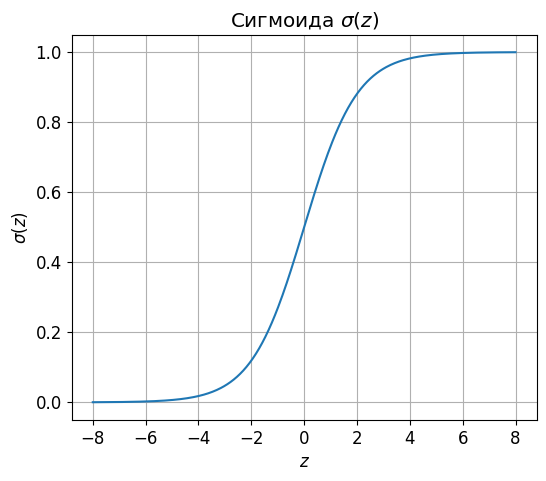

In [2]:
# Реализация сигмоиды

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Визуализация сигмоиды
z_vals = np.linspace(-8, 8, 400)
sigma_vals = sigmoid(z_vals)

plt.plot(z_vals, sigma_vals)
plt.xlabel("$z$")
plt.ylabel("$\\sigma(z)$")
plt.title("Сигмоида $\\sigma(z)$")
plt.grid(True)
plt.show()

### 2.2. Производная сигмоиды

Очень важное свойство сигмоиды — простая производная.

Начинаем с определения:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

После дифференцирования и упрощений получаем:

$$
\sigma'(z) = \sigma(z) (1 - \sigma(z)).
$$

Это крайне удобная форма: производная выражается через саму функцию.

Проверим это численно и графически.

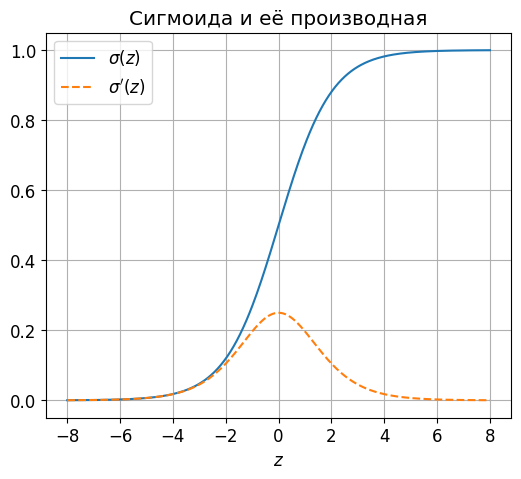

In [3]:
# Производная сигмоиды

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)


# Визуализация производной сигмоиды
z_vals = np.linspace(-8, 8, 400)
sigma_vals = sigmoid(z_vals)
sigma_deriv_vals = sigmoid_derivative(z_vals)

plt.plot(z_vals, sigma_vals, label="$\\sigma(z)$")
plt.plot(z_vals, sigma_deriv_vals, linestyle="--", label="$\\sigma'(z)$")
plt.xlabel("$z$")
plt.title("Сигмоида и её производная")
plt.grid(True)
plt.legend()
plt.show()

## 3. Правдоподобие логистической регрессии и функция потерь BCE

Логистическая регрессия — это **вероятностная модель**, которая предсказывает вероятность того, что объект относится к классу $1$:

$$
p_i = p(y^{(i)} = 1 \mid x^{(i)}) = \sigma(w^\top x^{(i)}).
$$

Следовательно:

$$
p(y^{(i)} = 0 \mid x^{(i)}) = 1 - p_i.
$$

---

### 3.1. Вероятность правильной метки одного объекта

Пусть метка $y^{(i)} \in \{0, 1\}$.  
Тогда вероятность того, что модель правильно предсказывает именно эту метку:

$$
p(y^{(i)} \mid x^{(i)}) = p_i^{\,y^{(i)}} (1 - p_i)^{\,1 - y^{(i)}}.
$$

Эта запись работает так:

| Метка $y^{(i)}$ | Выражение | Результат | Смысл |
|-----------------|-----------|-----------|-------|
| $1$ | $p_i^1 (1-p_i)^0$ | $p_i$ | модель считает вероятность класса 1 |
| $0$ | $p_i^0 (1-p_i)^1$ | $1 - p_i$ | модель считает вероятность класса 0 |

То есть мы берём:
- $p_i$, если истинный класс 1,  
- $1 - p_i$, если истинный класс 0.

---

### 3.2. Правдоподобие как вероятность «всё правильно одновременно»

Пусть у нас $n$ объектов.  
Предположим (как обычно в ML), что объекты **независимы**:  
с каждым объектом модель «угадывает» или «не угадывает» его метку независимо от остальных.

Тогда вероятность того, что *все объекты получили ровно те метки, которые наблюдаются*, равна:

$$
\mathcal{L}(w)
= \prod_{i=1}^n p(y^{(i)} \mid x^{(i)}).
$$

Это очень важно понимать интуитивно:

> **Правдоподобие — это вероятность события:  
> “первый объект имеет свою метку И второй объект имеет свою метку  
> И третий И … И все остальные тоже получили свои метки”.**

Произведение появляется именно из логики **совместной вероятности независимых событий**.

---

### 3.3. Интуитивный пример (очень важно!)

Рассмотрим 3 объекта:

| Объект | Истинный класс $y$ | $p(y=1 \mid x)$ | Вероятность правильной метки |
|--------|---------------------|------------------|-------------------------------|
| #1     | 1                   | 0.9              | $0.9$                         |
| #2     | 0                   | 0.2              | $1 - 0.2 = 0.8$               |
| #3     | 1                   | 0.7              | $0.7$                         |

Тогда правдоподобие модели:

$$
\mathcal{L} = 0.9 \cdot 0.8 \cdot 0.7 = 0.504.
$$

Это означает:

- модель «уверена» про объект #1 (0.9),  
- «уверена» про объект #2 (0.8),  
- умеренно уверена про объект #3 (0.7),  

и **вероятность того, что все три метки одновременно правильные** = 0.504.

Если модель выдаст худшие вероятности:

| Объект | Истинный $y$ | $p$ плохой модели | Вероятность правильной метки |
|--------|--------------|-------------------|-------------------------------|
| #1     | 1            | 0.6               | 0.6                           |
| #2     | 0            | 0.3               | 0.7                           |
| #3     | 1            | 0.55              | 0.55                          |

Правдоподобие:

$$
\mathcal{L} = 0.6 \cdot 0.7 \cdot 0.55 = 0.231.
$$

Правдоподобие стало меньше → модель хуже.

---

### 3.4. Почему мы максимизируем правдоподобие?

Потому что мы хотим:

> **найти такие параметры $w$, которые делают наблюдаемые данные максимально правдоподобными.**

То есть модель должна выдавать большие вероятности там, где $y=1$,  
и маленькие — там, где $y=0$.

Это классический принцип Maximum Likelihood Estimation (MLE).

---

### 3.5. Почему логарифм?

Работать с произведением неудобно:

- произведение $n$ маленьких чисел даёт числа около $0$,
- вычислительно неустойчиво,
- сложная производная.

Логарифм превращает произведение в сумму:

$$
\log \mathcal{L}(w)
= 
\sum_{i=1}^n
\left[
y^{(i)} \log p_i
+
(1 - y^{(i)}) \log(1 - p_i)
\right].
$$

Максимизация не изменяется, потому что логарифм — монотонная функция.

---

### 3.6. Функция потерь (отрицательное лог-правдоподобие)

Мы минимизируем:

$$
L(w)
= -
\sum_{i=1}^n
\left[
y^{(i)} \log p_i
+
(1 - y^{(i)}) \log(1 - p_i)
\right].
$$

А в усреднённом виде:

$$
L(w)
= -
\frac{1}{n}
\sum_{i=1}^n
\left[
y^{(i)} \log p_i
+
(1 - y^{(i)}) \log(1 - p_i)
\right].
$$

Это и есть **Binary Cross-Entropy (BCE)**.

Эта функция потерь:
- сильно штрафует **уверенные ошибки** (когда модель даёт $p \approx 1$ при $y = 0$ или наоборот),
- гладкая и дифференцируема,
- теоретически согласована с вероятностной постановкой.


---

### 3.7. Кратко

- Правдоподобие — это вероятность того, что все метки в данных совпадают с тем, что модель считает «правильным».
- Мы максимизируем эту вероятность → подбираем хорошие веса $w$.
- Логарифм превращает произведение вероятностей в удобную сумму.
- Негативное лог-правдоподобие — это и есть BCE, стандартный loss логистической регрессии.



### 3.8. Визуализация BCE для $y = 0$ и $y = 1$

Рассмотрим потери как функции от предсказанной вероятности $p \in (0, 1)$.

- При $y = 1$:

$$
L(p) = -\log p.
$$

- При $y = 0$:

$$
L(p) = -\log(1 - p).
$$

Посмотрим, как ведут себя эти функции.

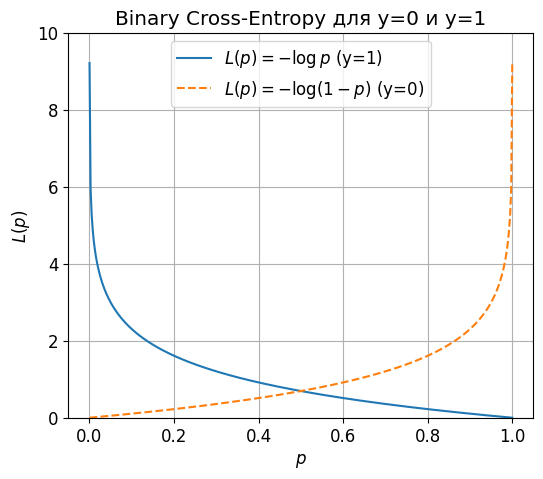

In [15]:
# Визуализация BCE для y=0 и y=1

p_vals = np.linspace(1e-4, 1 - 1e-4, 400)  # избегаем 0 и 1

loss_y1 = -np.log(p_vals)          # L(p) при y=1
loss_y0 = -np.log(1 - p_vals)      # L(p) при y=0

plt.plot(p_vals, loss_y1, label="$L(p) = -\\log p$ (y=1)")
plt.plot(p_vals, loss_y0, linestyle="--", label="$L(p) = -\\log(1-p)$ (y=0)")
plt.xlabel("$p$")
plt.ylabel("$L(p)$")
plt.title("Binary Cross-Entropy для y=0 и y=1")
plt.ylim(0, 10)
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Реализация BCE для векторов

def bce_loss(y_true, y_pred_proba):
    """
    y_true: массив меток (0/1)
    y_pred_proba: массив вероятностей p \\in (0, 1)
    """
    eps = 1e-9  # чтобы избежать log(0)
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    loss = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
    return loss

## 4. Градиент логистической регрессии

Рассмотрим один объект $(x, y)$, где $y \in \{0, 1\}$, 

$$
z = w^\top x, \quad p = \sigma(z).
$$

Функция потерь для одного объекта:

$$
\ell(w) = -\bigl[y \log p + (1 - y) \log(1 - p)\bigr].
$$

Найдём градиент $\nabla_w \ell(w)$ с помощью правила цепочки.

### 4.1. Расписываем цепочку производных

Имеем зависимость:

$$
w \rightarrow z = w^\top x \rightarrow p = \sigma(z) \rightarrow \ell(w).
$$

Применим правило цепочки:

$$
\frac{\partial \ell}{\partial w}
= \frac{\partial \ell}{\partial p}
\cdot \frac{\partial p}{\partial z}
\cdot \frac{\partial z}{\partial w}.
$$

1. Производная по $p$:

$$
\frac{\partial \ell}{\partial p}
= -\left(\frac{y}{p} - \frac{1 - y}{1 - p}\right).
$$

2. Производная $p$ по $z$ (используем производную сигмоиды):

$$
\frac{\partial p}{\partial z} = p (1 - p).
$$

3. Производная $z$ по $w$:

$$
\frac{\partial z}{\partial w} = x.
$$

### 4.2. Упрощение

Перемножая, получаем:

$$
\frac{\partial \ell}{\partial w}
= -\left(\frac{y}{p} - \frac{1 - y}{1 - p}\right) \cdot p (1 - p) \cdot x.
$$

Можно показать (сокращая $p$ и $1-p$), что это выражение упрощается до

$$
\frac{\partial \ell}{\partial w} = (p - y) x.
$$

### 4.3. Градиент на всей выборке

Если собрать все объекты в матрицу $X \in \mathbb{R}^{n \times d}$, вектор вероятностей $p \in \mathbb{R}^n$ и вектор меток $y \in \mathbb{R}^n$, то средний градиент по выборке:

$$
\nabla_w L(w) = \frac{1}{n} X^\top (p - y).
$$

Это очень простая и компактная формула:

- $X^\top (p - y)$ — «согласование ошибок» с признаками,
- деление на $n$ даёт средний градиент.

### 4.4. Шаг градиентного спуска

Алгоритм градиентного спуска обновляет веса:

$$
w \leftarrow w - \eta \nabla_w L(w),
$$

где $\eta > 0$ — шаг обучения (learning rate).


In [6]:
# Функции для вычисления прогноза, вероятностей и градиента

def predict_proba_logreg(X, w):
    """
    X: матрица признаков (n_samples, n_features)
    w: вектор параметров (n_features,)
    """
    z = X @ w
    return sigmoid(z)


def compute_gradient(X, y, w):
    """
    Вычисляет градиент BCE по параметрам w.
    X: (n_samples, n_features)
    y: (n_samples,)
    w: (n_features,)
    """
    p = predict_proba_logreg(X, w)
    grad = X.T @ (p - y) / X.shape[0]
    return grad

## 5. Синтетический датасет для бинарной классификации

Сгенерируем двумерный датасет из двух гауссовских кластеров (классы 0 и 1).

Затем:

- соберём матрицу признаков $X$,
- добавим фиктивный признак $1$ для свободного члена $w_0$ (bias),
- инициализируем параметры $w$,
- запустим градиентный спуск.


Форма X_raw: (400, 2)
Форма y: (400,)
Класс 0: 200
Класс 1: 200


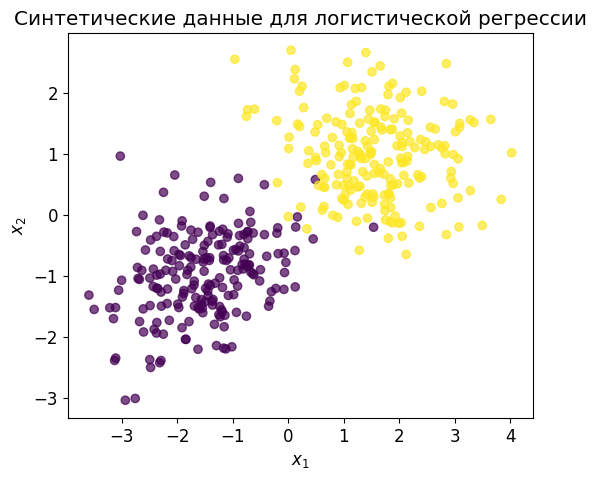

In [7]:
# Генерация синтетических данных

n_samples_per_class = 200

# Класс 0
mean0 = [-1.5, -1.0]
cov0 = [[0.8, 0.2],
        [0.2, 0.5]]
X0 = np.random.multivariate_normal(mean0, cov0, size=n_samples_per_class)
y0 = np.zeros(n_samples_per_class)

# Класс 1
mean1 = [1.5, 1.0]
cov1 = [[0.8, -0.1],
        [-0.1, 0.5]]
X1 = np.random.multivariate_normal(mean1, cov1, size=n_samples_per_class)
y1 = np.ones(n_samples_per_class)

# Объединяем
X_raw = np.vstack([X0, X1])
y = np.concatenate([y0, y1])

print("Форма X_raw:", X_raw.shape)
print("Форма y:", y.shape)
print("Класс 0:", np.sum(y == 0))
print("Класс 1:", np.sum(y == 1))

# Визуализация исходных данных
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y, alpha=0.7)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Синтетические данные для логистической регрессии")
plt.show()

### 5.1. Добавляем свободный член $w_0$

Для того чтобы модель логистической регрессии имела свободный член (bias), добавим в матрицу признаков столбец единиц.

Если исходно

$$
X_\text{raw} \in \mathbb{R}^{n \times 2},
$$

то после добавления bias-признака получаем матрицу

$$
X \in \mathbb{R}^{n \times 3},
$$

где первый столбец — единицы, а два остальных — исходные признаки.


In [8]:
# Добавляем столбец единиц для w0

n_samples = X_raw.shape[0]
X = np.hstack([np.ones((n_samples, 1)), X_raw])  # (n_samples, 3)

print("Форма X с bias-столбцом:", X.shape)

Форма X с bias-столбцом: (400, 3)


## 6. Обучение логистической регрессии градиентным спуском

Теперь реализуем полный цикл градиентного спуска:

1. Инициализация параметров $w$ (например, нулями или небольшим случайным шумом).
2. На каждой итерации:
   - считаем вероятности $p_i = \sigma(w^\top x^{(i)})$,
   - считаем функцию потерь BCE,
   - считаем градиент $\nabla_w L(w)$,
   - обновляем параметры по правилу

$$
w \leftarrow w - \eta \nabla_w L(w).
$$

3. Логируем значения функции потерь (и accuracy) по эпохам.


In [9]:
# Функция для расчёта accuracy при пороге 0.5

def accuracy_score_binary(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [19]:
# Реализация градиентного спуска для логистической регрессии

def train_logistic_regression_gd(X, y, lr=0.1, n_epochs=200):
    """
    Обучение логистической регрессии градиентным спуском.

    X: (n_samples, n_features) - признаки (с bias-столбцом)
    y: (n_samples,) - метки 0/1
    lr: шаг обучения (learning rate)
    n_epochs: количество эпох

    Возвращает:
    w_history: список параметров w на каждой эпохе
    loss_history: значения BCE на каждой эпохе
    acc_history: значения accuracy на каждой эпохе
    """
    n_samples, n_features = X.shape
    # Инициализируем параметры нулями
    w = np.zeros(n_features)

    w_history = []
    loss_history = []
    acc_history = []

    for epoch in range(n_epochs):
        # Предсказанные вероятности
        p = predict_proba_logreg(X, w)

        # BCE-loss
        loss = bce_loss(y, p)

        # Accuracy
        acc = accuracy_score_binary(y, p)

        # Градиент
        grad = compute_gradient(X, y, w)

        # Шаг градиентного спуска
        w = w - lr * grad

        # Логируем
        w_history.append(w.copy())
        loss_history.append(loss)
        acc_history.append(acc)

        if (epoch + 1) % 1 == 0:
            print(f"Эпоха {epoch+1:4d} | Loss = {loss:.4f} | Accuracy = {acc:.4f}")

    return np.array(w_history), np.array(loss_history), np.array(acc_history)

In [20]:
# Обучаем логистическую регрессию

lr = 0.1       # шаг обучения
n_epochs = 100 # число эпох

w_history, loss_history, acc_history = train_logistic_regression_gd(X, y, lr=lr, n_epochs=n_epochs)

w_final = w_history[-1]
print("\nИтоговые параметры w:")
print(w_final)

Эпоха    1 | Loss = 0.6931 | Accuracy = 0.5000
Эпоха    2 | Loss = 0.6147 | Accuracy = 0.9850
Эпоха    3 | Loss = 0.5511 | Accuracy = 0.9850
Эпоха    4 | Loss = 0.4993 | Accuracy = 0.9850
Эпоха    5 | Loss = 0.4566 | Accuracy = 0.9850
Эпоха    6 | Loss = 0.4211 | Accuracy = 0.9850
Эпоха    7 | Loss = 0.3911 | Accuracy = 0.9850
Эпоха    8 | Loss = 0.3657 | Accuracy = 0.9850
Эпоха    9 | Loss = 0.3438 | Accuracy = 0.9850
Эпоха   10 | Loss = 0.3248 | Accuracy = 0.9850
Эпоха   11 | Loss = 0.3081 | Accuracy = 0.9850
Эпоха   12 | Loss = 0.2934 | Accuracy = 0.9850
Эпоха   13 | Loss = 0.2803 | Accuracy = 0.9850
Эпоха   14 | Loss = 0.2686 | Accuracy = 0.9850
Эпоха   15 | Loss = 0.2581 | Accuracy = 0.9875
Эпоха   16 | Loss = 0.2485 | Accuracy = 0.9875
Эпоха   17 | Loss = 0.2399 | Accuracy = 0.9875
Эпоха   18 | Loss = 0.2319 | Accuracy = 0.9875
Эпоха   19 | Loss = 0.2247 | Accuracy = 0.9875
Эпоха   20 | Loss = 0.2180 | Accuracy = 0.9875
Эпоха   21 | Loss = 0.2118 | Accuracy = 0.9875
Эпоха   22 | 

### 6.1. Динамика функции потерь и accuracy

Посмотрим, как в процессе обучения менялись:

- значение BCE-потерь,
- точность классификации (accuracy).

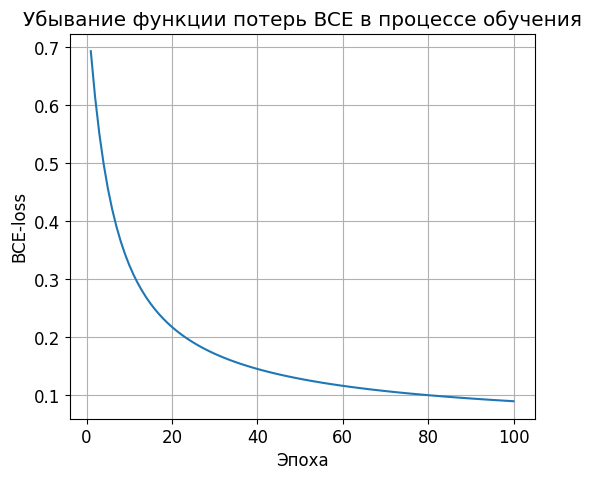

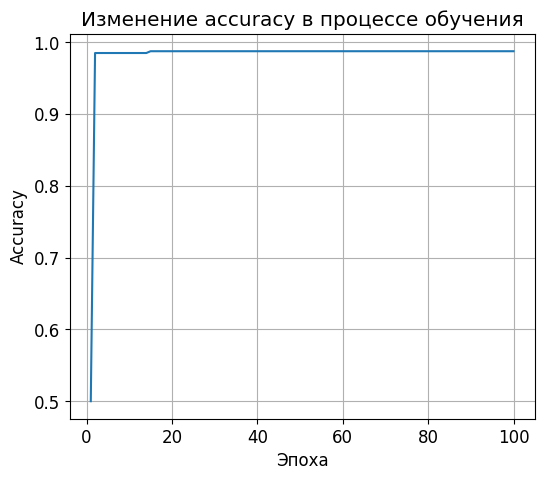

In [21]:
epochs = np.arange(1, len(loss_history) + 1)

plt.plot(epochs, loss_history)
plt.xlabel("Эпоха")
plt.ylabel("BCE-loss")
plt.title("Убывание функции потерь BCE в процессе обучения")
plt.grid(True)
plt.show()

plt.plot(epochs, acc_history)
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Изменение accuracy в процессе обучения")
plt.grid(True)
plt.show()

## 7. Визуализация разделяющей границы логистической регрессии

Модель логистической регрессии задаёт вероятность класса $1$ как

$$
p(y = 1 \mid x) = \sigma(w_0 + w_1 x_1 + w_2 x_2).
$$

Разделяющая граница при пороге $0.5$ определяется условием

$$
p = 0.5 \quad \Leftrightarrow \quad \sigma(w_0 + w_1 x_1 + w_2 x_2) = 0.5.
$$

Функция $\sigma(z)$ принимает значение $0.5$ при $z = 0$, поэтому:

$$
w_0 + w_1 x_1 + w_2 x_2 = 0.
$$

Это уравнение **прямой** в пространстве $(x_1, x_2)$.

Построим эту прямую и покажем, как она разделяет два класса.


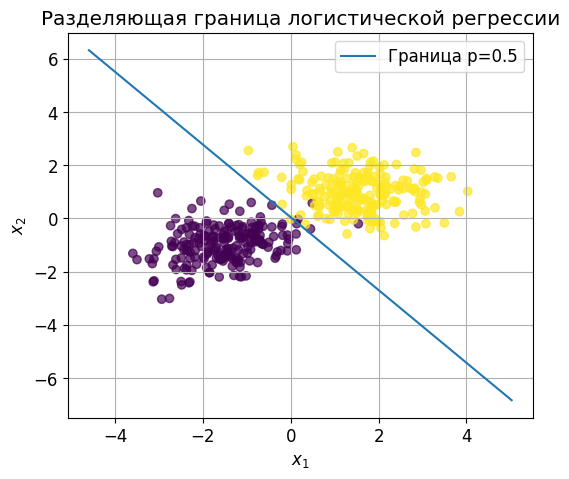

In [22]:
# Визуализация разделяющей границы

def plot_decision_boundary_logreg(X_raw, y, w, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Отобразим точки
    ax.scatter(X_raw[:, 0], X_raw[:, 1], c=y, alpha=0.7)

    # Построим прямую w0 + w1 x1 + w2 x2 = 0
    x1_min, x1_max = X_raw[:, 0].min() - 1, X_raw[:, 0].max() + 1
    x1_vals = np.linspace(x1_min, x1_max, 200)

    w0, w1, w2 = w
    # w0 + w1 x1 + w2 x2 = 0 => x2 = -(w0 + w1 x1) / w2
    x2_vals = -(w0 + w1 * x1_vals) / w2

    ax.plot(x1_vals, x2_vals, label="Граница p=0.5")

    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    ax.legend()
    ax.grid(True)


fig, ax = plt.subplots()
plot_decision_boundary_logreg(X_raw, y, w_final, ax=ax, title="Разделяющая граница логистической регрессии")
plt.show()

## 8. Траектория градиентного спуска в пространстве параметров

У нас три параметра:

- $w_0$ — свободный член,
- $w_1$ — коэффициент при $x_1$,
- $w_2$ — коэффициент при $x_2$.

На каждой эпохе мы обновляем $w$, поэтому можно отследить **траекторию движения** вектора параметров в 3D-пространстве:

$$
(w_0^{(t)}, w_1^{(t)}, w_2^{(t)}), \quad t = 0, 1, \dots, T.
$$

Построим эту траекторию.


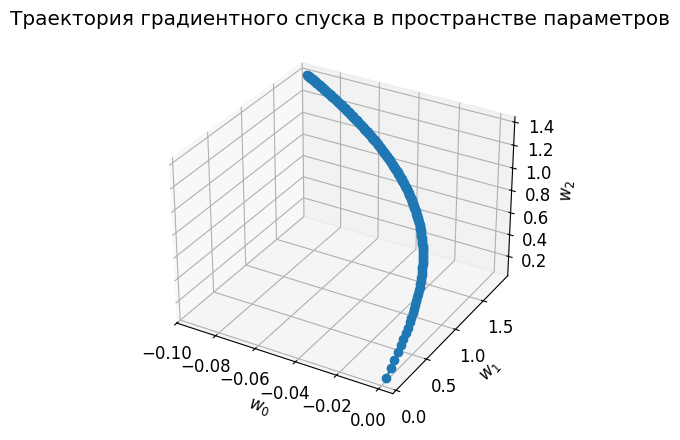

In [14]:
# Визуализация траектории параметров в 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

w0_vals = w_history[:, 0]
w1_vals = w_history[:, 1]
w2_vals = w_history[:, 2]

ax.plot(w0_vals, w1_vals, w2_vals, marker="o")

ax.set_xlabel("$w_0$")
ax.set_ylabel("$w_1$")
ax.set_zlabel("$w_2$")
ax.set_title("Траектория градиентного спуска в пространстве параметров")
plt.show()

## 9. Выводы

В этом ноутбуке мы:

1. Ввели сигмоидную функцию $\sigma(z)$ и рассмотрели её свойства.
2. Разобрали функцию потерь Binary Cross-Entropy (BCE) как отрицательное лог-правдоподобие.
3. Аккуратно вывели градиент логистической регрессии и получили компактную формулу

$$
\nabla_w L = \frac{1}{n} X^\top (p - y).
$$

4. Реализовали логистическую регрессию **полностью вручную** с помощью градиентного спуска.
5. Обучили модель на двумерных синтетических данных и визуализировали:
   - убывание функции потерь,
   - рост accuracy,
   - разделяющую границу на плоскости признаков,
   - траекторию параметров в пространстве $(w_0, w_1, w_2)$.

Следующий естественный шаг — сравнить нашу реализацию с `LogisticRegression` из `sklearn`, добавить различные метрики качества (precision, recall, F1, ROC-AUC) и поработать с более сложными/шумными датасетами.
